In [1]:
import pandas as pd
import numpy as np
import re
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from unidecode import unidecode

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Chargement des fichiers
Chargement du petit dataset ne contenant qu'une partie des lignes du dataset original (pour fair les tests et analyse rapidement) et de la liste des colonnes interessantes selon les besoins (Client, Score, Algo)

In [2]:
from listes import *

In [3]:
# Chargement du dataset complet (320772, 162)
#data = pd.read_csv('./data/fr.openfoodfacts.org.products.csv', delimiter='\t', low_memory=False)

In [4]:
# Création d'un extrait du dataset pour charger et expérimenter plus rapidement
#data_petit = data.iloc[np.random.randint(0, len(data), 50000)]
#data_petit.to_csv("./data/data_petit.csv")

In [5]:
# Chargement du dataset version réduite (50000 valeurs pour les tests)
data = pd.read_csv("./data/data_petit.csv", low_memory=False)

On se contente de garder uniquement les colonnes qui nous seront utiles

In [6]:
data = data.loc[:, listeColones]

## Apercu du dataset

In [7]:
data.head()

,code,product_name,image_url,categories_tags,pnns_groups_1,pnns_groups_2,ingredients_text,additives_n,additives,additives_tags,...,quantity,brands,brands_tags,categories,main_category,main_category_fr,energy-from-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,alcohol_100g
0,4311501391952,Paprika,http://fr.openfoodfacts.org/images/products/43...,"en:plant-based-foods-and-beverages,en:plant-ba...",Fruits and vegetables,Vegetables,"34% Paprika grün, 33% Paprika rot, 33% Paprika...",0.0,[ 34-paprika-grun -> de:34-paprika-grun ] [...,NaN,...,1000 g,Edeka,edeka,Sweet Peppers,en:fresh-vegetables,Légumes frais,NaN,NaN,NaN,NaN
1,4260140893016,Habañero Käse Kessel Chips,NaN,"en:salty-snacks,en:appetizers,en:chips-and-fri...",Salty snacks,Appetizers,"Kartoffeln, Sonnenblumenöl, Speisesalz, Zucker...",1.0,[ kartoffeln -> de:kartoffeln ] [ sonnenblu...,en:e330,...,125 g,Pepper-King,pepper-king,Kartoffelchips,en:chips-and-fries,Chips et frites,NaN,NaN,NaN,NaN
2,0078742433042,Sweetened Condensed Milk,NaN,NaN,NaN,NaN,"Milk, sugar",0.0,[ milk -> en:milk ] [ sugar -> en:sugar ],NaN,...,NaN,Great Value,great-value,NaN,NaN,NaN,NaN,2.56,0.0,NaN
3,6942836700218,HERSHEY'S KISSES 扁桃仁牛奶巧克力,http://fr.openfoodfacts.org/images/products/69...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,95g,HERSHEY'S,hershey-s,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0025315248701,"Marie Sharp's, Orange Pulp Habanero Pepper Sau...",NaN,NaN,NaN,NaN,"Select yellow habanero peppers, orange pulp, o...",0.0,[ select-yellow-habanero-peppers -> en:select...,NaN,...,NaN,Melinda's Limited,melinda-s-limited,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print("Fichier de dimension " + str(data.shape) + " :\n")

print("\n\nType des colonnes :")
print(data.dtypes.to_markdown())

print("\n\nTaux de remplissage (%) :")
print(((1- data.isna().mean())*100).to_markdown())

print("\n\nNombre de valeurs uniques par colones :")
print(data.nunique().to_markdown())

Fichier de dimension (50000, 38) :



Type des colonnes :
|                                            | 0       |
|:-------------------------------------------|:--------|
| code                                       | object  |
| product_name                               | object  |
| image_url                                  | object  |
| categories_tags                            | object  |
| pnns_groups_1                              | object  |
| pnns_groups_2                              | object  |
| ingredients_text                           | object  |
| additives_n                                | float64 |
| additives                                  | object  |
| additives_tags                             | object  |
| ingredients_from_palm_oil_n                | float64 |
| ingredients_from_palm_oil_tags             | object  |
| ingredients_that_may_be_from_palm_oil_n    | float64 |
| ingredients_that_may_be_from_palm_oil_tags | object  |
| nutrition_grade_fr          

### Widget pour lire le dataset plus facilement

In [9]:
@interact
def show_describe(column=list(data.columns)):
    return data[column].describe().T

interactive(children=(Dropdown(description='column', options=('code', 'product_name', 'image_url', 'categories…

In [10]:
@interact
def show_extract(column=list(data.columns), x=(0, 300, 1)):
    tmp = data.loc[~data[column].isna(), column]
    return tmp.iloc[x:x+10]

interactive(children=(Dropdown(description='column', options=('code', 'product_name', 'image_url', 'categories…

# Analyse des valeurs manquantes

In [11]:
# Matrice des valeurs manquantes
# msno.matrix(data)

In [12]:
(data['image_url'].isna() & data['categories'].isna()).mean()

0.69136

Diagramme du remplissage de chaque colonne

<AxesSubplot: >

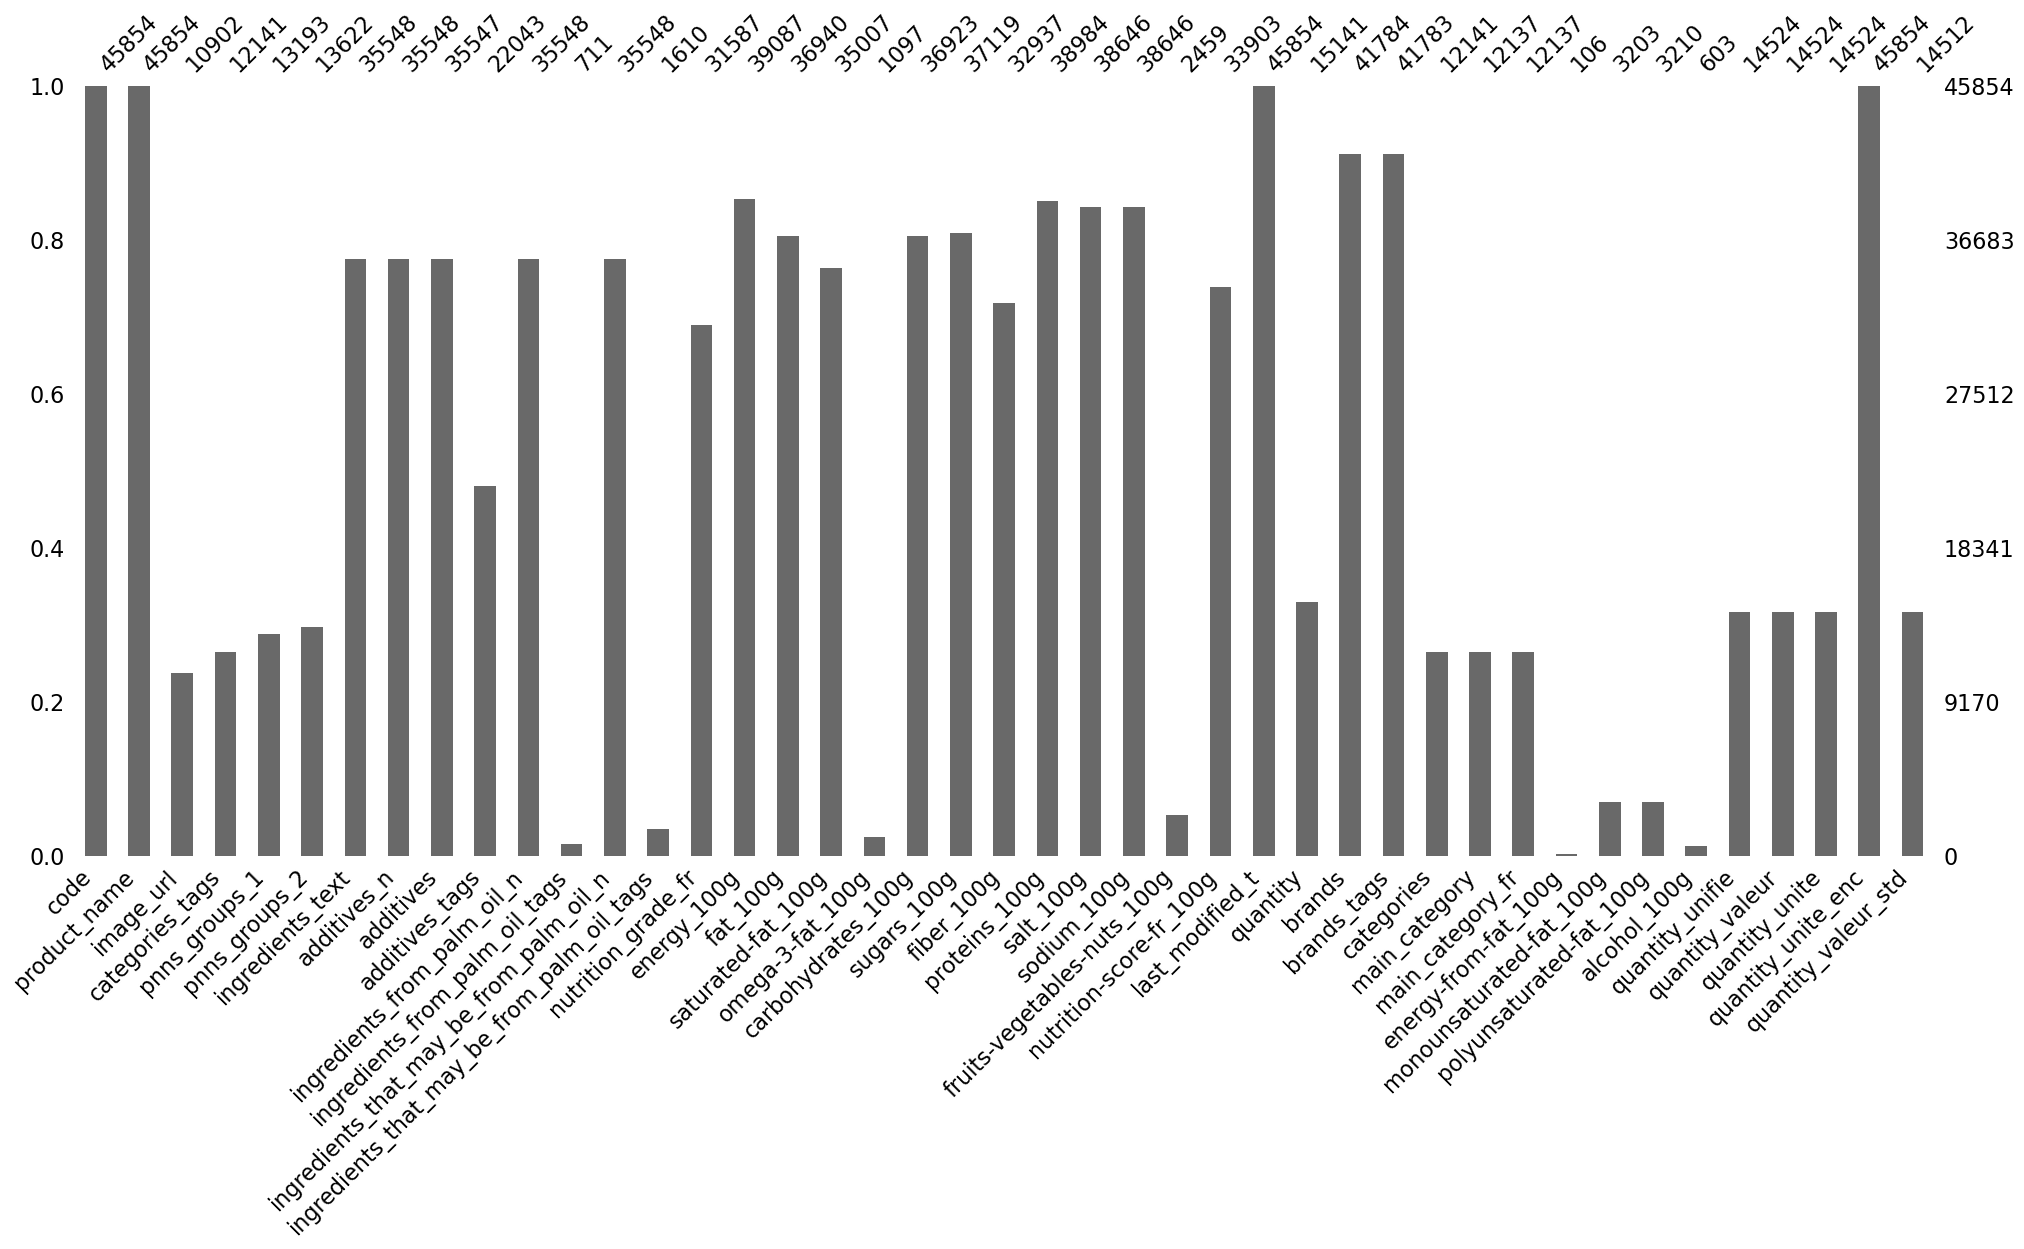

In [221]:
msno.bar(data)

On peut remarquer que beaucoupnde categories sont très vides. Certaines le sont surement car c'est une manière de marquer l'absence de quelquechose (très peu de valeurs dans "ingredients from palm oil" alors que ingredient text est assez remplis, cela signifie peut-être que pour beaucoup, pas de valeur = pas d'ingredients concernés.

Dans l'ensemble, le dataset semble assez bien remplis, surtout si une partie des valeurs peuvent être imputées facilement.

### Dentogramme des liens entre les colonnes

<AxesSubplot: >

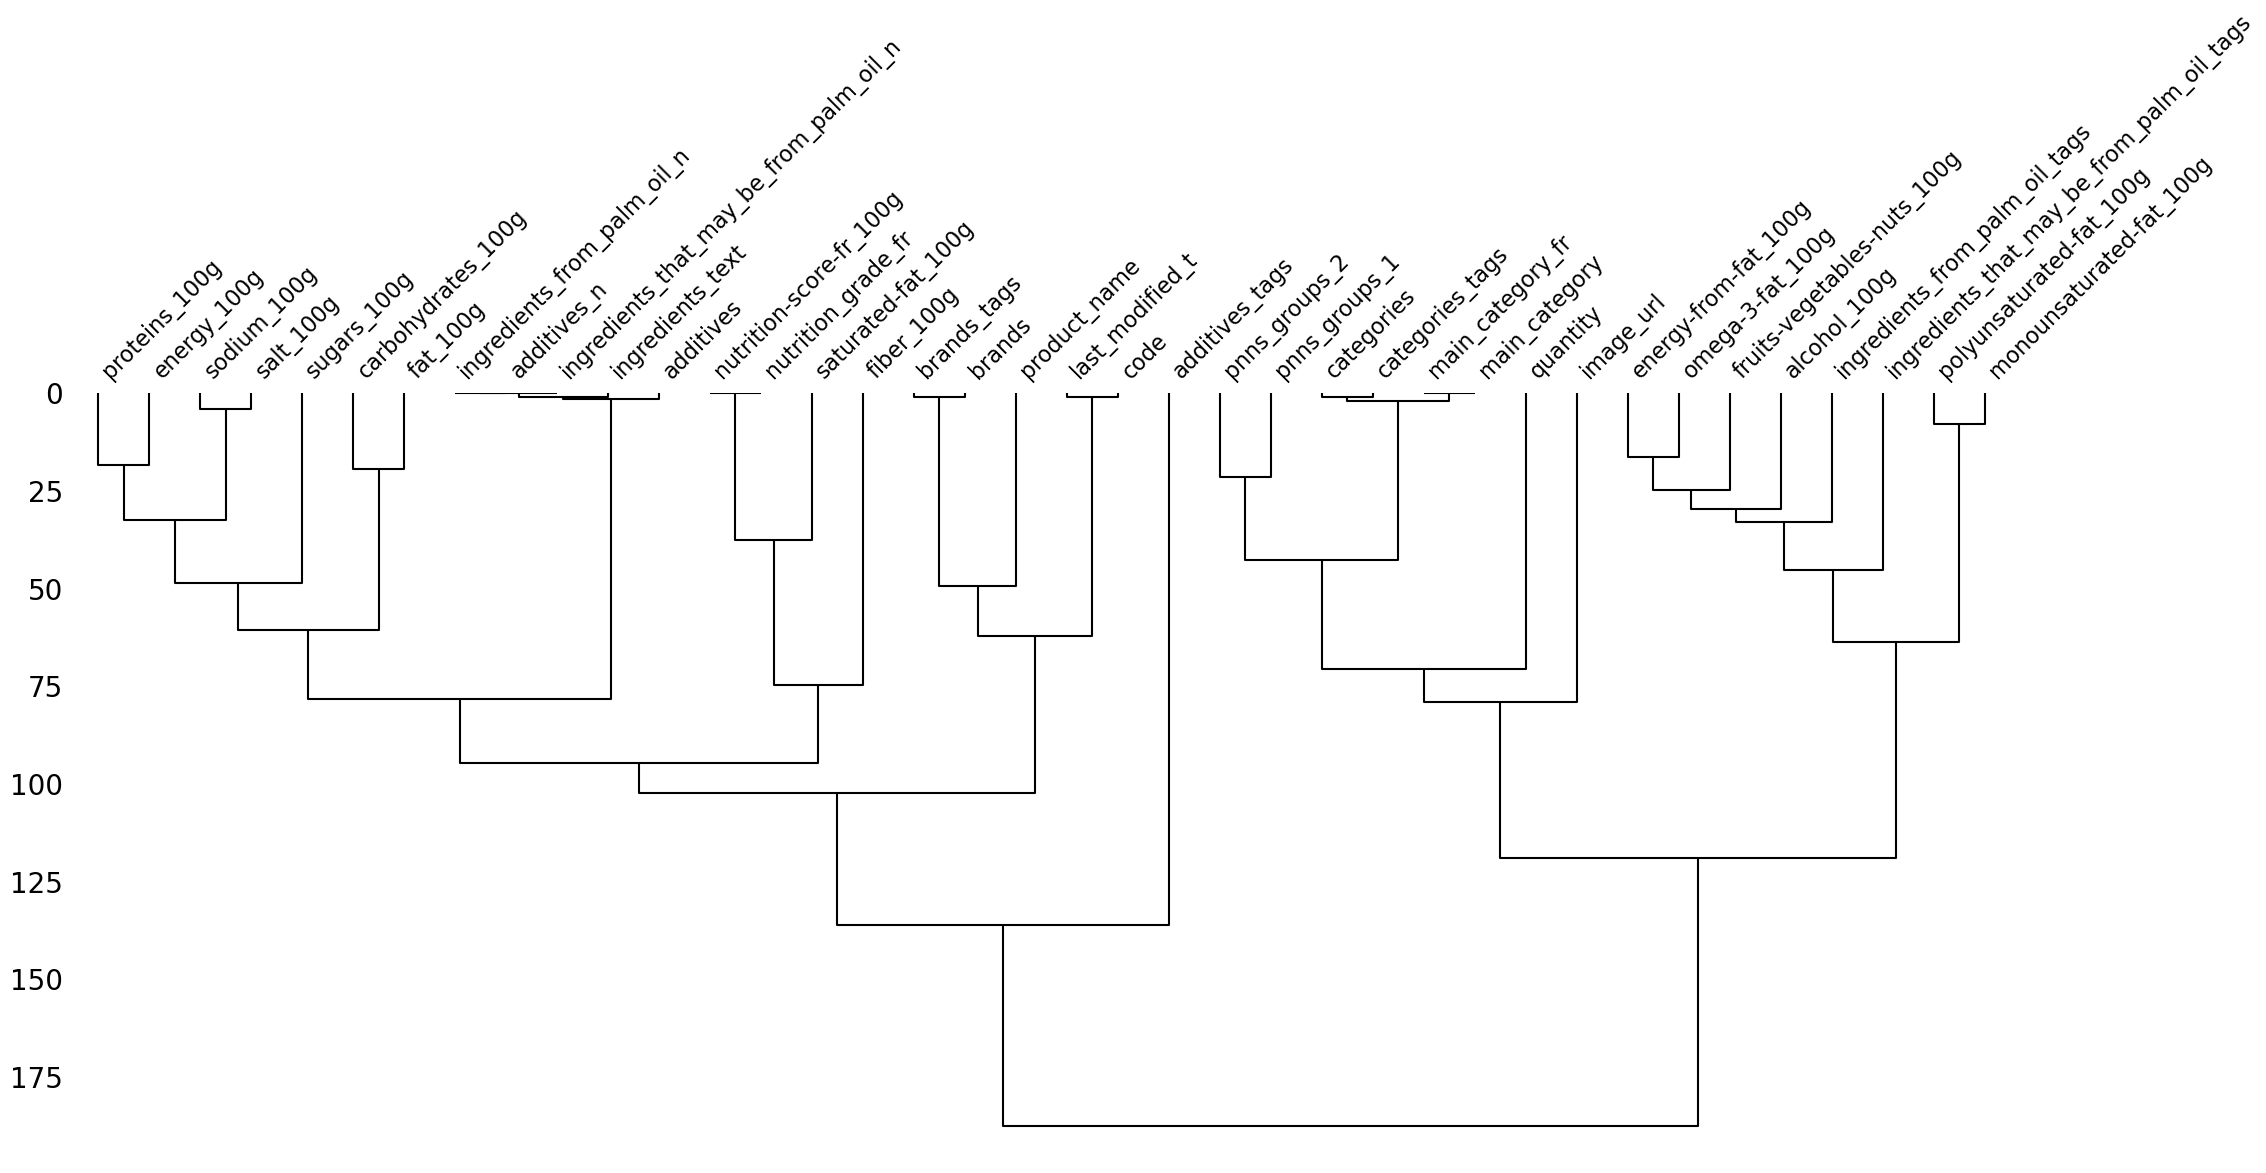

In [14]:
msno.dendrogram(data)

# Analyse des valeurs abérantes

## Suppression des lignes dans les valeurs abérantes pour les codes
Suppression des lignes quand il n'y a pas de code, ou que ce dernier n'est pas correcte (8, 12 ou 13 chiffres), et on ne garde que le code le plus recent

In [15]:
data = data.loc[data['code'].str.len().isin([8,12,13])]

In [16]:
data = data[data['code'].apply(lambda x: str(x).isdigit())]

In [17]:
data = data.sort_values(by='last_modified_t')

nb = len(data)
data = data[~data.duplicated(subset=['code'], keep="last")]

print("On a supprimé " + str(nb - len(data)) + " lignes")

On a supprimé 3637 lignes


In [18]:
print("Tous les codes sont-ils bien uniques?")
print("Oui") if len(data.loc[data['code'].duplicated()]) == 0 else print("Non")

Tous les codes sont-ils bien uniques?
Oui


## Remplacement des NaN par des " "

Pour les noms des produits, 

In [19]:
data['product_name'].fillna(value='', inplace=True)

## Valeurs abérantes sur les informations nutritionelles
Affichage des valeurs abérantes pour la nouriture (l'énergie entre 0 et 3800kj, nutriscore entre -15 et 40, et le reste doit être entre 0 et 100)

In [20]:
for c in [c for c in data.columns if c.endswith('_100g')]:
    print(c)
    
    tmp = None
    
    if c.startswith('energy'):
        tmp = data.loc[~((data[c]<=3800) & (data[c]>=0) | data[c].isna()), ['code', 'product_name', c]]
    elif c.startswith('nutrition'):
        tmp = data.loc[~((data[c]<=40) & (data[c]>=-15) | data[c].isna()), ['code', 'product_name', c]]
    else:
        tmp = data.loc[~((data[c]<=100) & (data[c]>=0) | data[c].isna()), ['code', 'product_name', c]]
    
    if len(tmp) == 0:
        print('Rien\n')
    else:
        print(tmp.to_markdown(), '\n')

energy_100g
|       |          code | product_name                                                          |   energy_100g |
|------:|--------------:|:----------------------------------------------------------------------|--------------:|
| 48838 | 8854404001734 |                                                                       |         87217 |
| 31776 | 2107391007453 |                                                                       |         16000 |
| 14057 | 7613312066638 |                                                                       |          8400 |
|  6332 | 3256221675573 | Purée Nature                                                          |          6138 |
| 23090 | 3560070909520 | Jamón  de Cebo Iberico                                                |          5611 |
| 28599 | 3760151013232 | Biscuits Son D'avoine Nappés Chocolat 12 Biscuits                     |          6063 |
|  6712 | 3230890027529 | 1KG Nuggets Poulet Maitre Coq                     

Rien

energy-from-fat_100g
Rien

monounsaturated-fat_100g
Rien

polyunsaturated-fat_100g
Rien

alcohol_100g
Rien



In [21]:
# Suppression des valeurs non comprises entre 0 et 100
for c in ['fat_100g', 'saturated-fat_100g', 'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
         'omega-3-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
         'fruits-vegetables-nuts_100g', 'alcohol_100g']:
    data.loc[~((data[c]<=100) & (data[c]>=0)), [c]] = np.NaN

In [22]:
# Suppression des valeurs non comprises entre 0 et 3800
data.loc[~((data['energy_100g']<=3800) & (data['energy_100g']>=0)), ['energy_100g']] = np.NaN

In [23]:
# Réduction des valeurs > a 100, puis suppression si toujours pas entre 0 et 100
for c in ['salt_100g', 'sodium_100g']:    
    mask = ~(data[c]<=100)
    data.loc[mask, [c]] = data.loc[mask, [c]]/1000
    
    data.loc[~((data[c]<=100) & (data[c]>=0)), [c]] = np.NaN

## Valeurs nutritionelles incohérentes
Affichage des valeurs non cohérentes (kj avec le reste, sodium<sel, sucre<carbohydrate, somme des gras < fat)

In [24]:
for c1, c2 in [('salt_100g', 'sodium_100g'), ('carbohydrates_100g', 'sugars_100g'), ('fat_100g', 'saturated-fat_100g')]:
    mask = data[c1]<data[c2]
    tmp = data.loc[mask, ['code', 'product_name', c1, c2]]
    
    print(c1, 'vs', c2)
    if len(tmp) == 0:
        print('Rien\n')
    else:
        print(tmp, '\n')

salt_100g vs sodium_100g
                code                         product_name  salt_100g  \
34371  0024600017008                   Coarse Kosher Salt   0.102000   
37038  0089397105253                        Fine Sea Salt   0.113322   
10694  0052100020402                 Steak Seasoning Salt   0.104140   
1132   0632930413942               Flower Of Salt, Smoked   0.108712   
14825       20035389                  Himalayan Pink Salt   0.106680   
5382   0857689447233                      Molten Hot Salt   0.118364   
16089  0608291082974                             Sea Salt   0.149860   
9084   0050428447222                     Sea Salt Grinder   0.101600   
40197  0030034088941                        Fine Sea Salt   0.101600   
41710  0752423657483                      Pegs, Pink Salt   0.121920   
12535  0813568002733            Quinoa Curvo Rigate Pasta   0.133685   
1734   0810487284028  Sweet Goodies White Chocolate Balls   0.181430   
42341  0096619911936                  H

Et inversion de ces valeurs (pour le sel et le sodium, je préfère recalculer)

In [25]:
#('salt_100g', 'sodium_100g'), 
for c1, c2 in [('carbohydrates_100g', 'sugars_100g'), ('fat_100g', 'saturated-fat_100g')]:
    mask = data[c1]<data[c2]
    tmp = data[c1].copy()
    data.loc[mask, c1] = data[c2]
    data.loc[mask, c2] = tmp

## Calcul de certaines valeurs

Calcul du sodium et du sel

In [26]:
data.loc[~data['salt_100g'].isna(), 'sodium_100g'] = data.loc[~data['salt_100g'].isna(), 'salt_100g'] * 0.4
data.loc[~data['sodium_100g'].isna(), 'salt_100g'] = data.loc[~data['sodium_100g'].isna(), 'sodium_100g'] * 2.5

In [27]:
data[['code', 'product_name', 'salt_100g']].sort_values(by='salt_100g', ascending=False, na_position='last').head(5)

,code,product_name,salt_100g
36773,4001475112607,Meersalz mit Jod,100.00000
20001,8480017457707,Sel fin de met iodé,100.00000
13023,3445850020339,Fleur de sel de Guérande,100.00000
24681,0024600010863,All-Natural Canning & Pickling Salt For Preser...,99.90582
22987,0011150246989,Iodized Salt,99.90582


Les _n

In [28]:
l = ['additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n']
data.fillna(0)

,code,product_name,image_url,categories_tags,pnns_groups_1,pnns_groups_2,ingredients_text,additives_n,additives,additives_tags,...,quantity,brands,brands_tags,categories,main_category,main_category_fr,energy-from-fat_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,alcohol_100g
40130,5601286260024,Linguine al pesto,http://fr.openfoodfacts.org/images/products/56...,pt:pates-au-pesto,unknown,unknown,"semoule de blé dur, pesto (1,5%), basilic, fro...",0.0,[ semoule-de-ble-dur -> pt:semoule-de-ble-dur...,0,...,500 g,Milaneza,milaneza,Pâtes au pesto,pt:pates-au-pesto,pt:Pates-au-pesto,0.0,0.0,0.0,0.0
27264,4005514171303,Pâté Shiitake,http://fr.openfoodfacts.org/images/products/40...,"en:plant-based-foods-and-beverages,en:plant-ba...",unknown,unknown,"levure alimentaire, eau, huile de palmiste non...",0.0,[ levure-alimentaire -> fr:levure-alimentaire...,0,...,125g,Tartex,tartex,Paté végétal,en:spreads,Produits à tartiner,0.0,0.0,0.0,0.0
17964,3421557904004,Galettes 5 céréales,http://fr.openfoodfacts.org/images/products/34...,"en:plant-based-foods-and-beverages,en:plant-ba...",Cereals and potatoes,Cereals,"riz, blé, maïs, avoine, sarrasin, sel",0.0,[ riz -> fr:riz ] [ ble -> fr:ble ] [ mai...,0,...,130g,Grillon d'or,grillon-d-or,Galettes de céréales,en:plant-based-foods-and-beverages,Aliments et boissons à base de végétaux,0.0,0.0,0.0,0.0
48090,3245411776008,Chocolat en poudre Intense,http://fr.openfoodfacts.org/images/products/32...,"en:breakfasts,en:sugary-snacks,en:chocolates,e...",Sugary snacks,Chocolate products,"Sucre, cacao maigre (à 11% de beurre de cacao)...",1.0,[ sucre -> fr:sucre ] [ cacao-maigre -> fr:...,en:e322,...,1kg,Carrefour,carrefour,Chocolat en poudre,en:breakfasts,Petit-déjeuners,0.0,0.0,0.0,0.0
25207,3271792742509,Malta Corsaire,http://fr.openfoodfacts.org/images/products/32...,"en:beverages,en:carbonated-drinks,en:sodas,en:...",Beverages,Sweetened beverages,"eau, malt, sucre de canne, colorant : caramel ...",1.0,[ eau -> fr:eau ] [ malt -> fr:malt ] [ s...,en:e150c,...,50 cL,Corsaire,corsaire,sodas,en:sodas,Sodas,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12670,4316268394741,Vollkorn Spaghetti,0,"en:plant-based-foods-and-beverages,en:plant-ba...",Cereals and potatoes,Cereals,0,0.0,0,0,...,500 g,BioBio,biobio,"Plant-based foods and beverages,Plant-based fo...",en:pastas,Pâtes alimentaires,0.0,0.0,0.0,0.0
41334,4316268455626,Pesto alla Genovese,0,0,unknown,unknown,0,0.0,0,0,...,190 g,Mondo Italiano,mondo-italiano,0,0,0,0.0,0.0,0.0,0.0
7530,24672481,Pudding z okusom gozdni sadeži,0,"en:desserts,en:puddings",unknown,unknown,"škrob (koruza), barvilo antocianini, aroma, je...",0.0,[ škrob -> sl:škrob ] [ koruza -> sl:koruza...,0,...,37 g,Bella,bella,"Desserts,Puddings",en:desserts,Desserts,0.0,0.0,0.0,0.0
2928,3288110822072,Milumel bio 3 croissance,0,"en:baby-foods,en:baby-milks",unknown,unknown,"Lait écrémé, maltodextrines, matières grasses ...",8.0,[ lait-ecreme -> fr:lait-ecreme ] [ lait ->...,"en:e341,en:e525,en:e516,en:e519,en:e518,en:e32...",...,0,Lactel,lactel,"Aliments pour bébé,Laits pour bébé",en:baby-foods,Aliments pour bébé,0.0,0.0,0.0,0.0


Separer quantity en une valeur norme et unité

In [180]:
data['quantity'] = data['quantity'].str.lower()

In [181]:
listeUnite = data.loc[data['quantity'].notna(), 'quantity'].str.extract(r'([a-z]+)', flags=re.I, expand=True).stack()

In [182]:
print("Nombre d'unites differentes :", len(listeUnite.value_counts()))
print("Voici les valeurs les plus représentées :")
listeUnite.value_counts().head(20)

Nombre d'unites differentes : 180
Voici les valeurs les plus représentées :


g           10499
ml            928
l             902
cl            630
kg            604
x             194
gr            164
oz            115
litre          67
grammes        41
fl             31
sachets        20
tranches       17
portions       11
poids          11
litres         10
oeufs           9
pi              8
lb              8
biscuits        7
dtype: int64

In [183]:
def convert_unit(txt, get_u=None):
    if txt is np.NaN:
        return np.NaN
    
    tradUnit = {
        'gr':'g',
        'grs':'g',
        'gm':'g',
        'gms':'g',
        'litre':'l',
        'liter':'l',
        'litro':'l',
        'litros':'l',
        'liters':'l',
        'litres':'l',
        'litters':'l',
        'litter':'l',
        'littes':'l',
        'gallon':'gal',
        'galon':'gal',
        'gallons':'gal',
        'galons':'gal',
        'lt':'l',
        'lts':'l',
        'grammes':'g',
        'grams':'g',
        'gram':'g',
        'grm':'g',
        'gramms':'g',
        'gramme':'g',
        'gramm':'g',
        'gramos':'g',
        'kilos':'kg',
        'lbs':'lb'
    }
    for m, u in re.findall(r'([0-9]+)\ *([a-z]+)', txt):
        if u in tradUnit:
            u = tradUnit[u]
        
        if get_u == 'm':
            return m
        elif get_u == 'u':
            return u
        else:
            return m + ' ' + u

In [184]:
from sklearn.preprocessing import *

In [185]:
data['quantity_unifie'] = data['quantity'].apply(convert_unit)
data['quantity_valeur'] = pd.to_numeric(data['quantity'].apply(lambda x : convert_unit(x, 'm')))
data['quantity_unite'] = data['quantity'].apply(lambda x : convert_unit(x, 'u'))

In [186]:
# Encodage des unites
enc = LabelEncoder().fit(data['quantity_unite'])
data['quantity_unite_enc'] = pd.to_numeric(enc.transform(data['quantity_unite']))

In [187]:
data['quantity_unite'].unique()

array(['g', 'kg', 'cl', 'ml', 'l', nan, 'tranches', 'x', None, 'oeufs',
       'ge', 'unit', 'units', 'uova', 'pieza', 'tartelettes', 'pint',
       'oz', 'fruits', 'mg', 'pi', 'porciones', 'cabezas', 'fl', 'can',
       'eggs', 'stems', 'cauliflower', 'bouteilles', 'pk', 'capsules',
       'pack', 'citrons', 'pots', 'stk', 'caramels', 'pieces', 'servings',
       'planches', 'lb', 'kp', 'produits', 'bars', 'cups', 'gal',
       'cookies', 'cans', 'tarts', 'parts', 'biscuits', 'piezas', 'tea',
       'st', 'pains', 'sandwich', 'tsp', 'bo', 'sachets', 'bunch',
       'planta', 'chips', 'drag', 'ou', 'portions', 'b', 'pommes', 'par',
       'batonnets', 'pilons', 'dosettes', 'pastilles', 'sachet',
       'sabores', 'mousselines', 'teabags', 'head', 'botte', 'paquets',
       'kopf', 'banane', 'bund', 'mini', 'grd', 'personnes', 'pads',
       'topf', 'o', 'gourdes', 'oog', 'k', 'pcs', 'filets', 'barres',
       'comprimes', 'gratuits', 'hg', 'bottle', 'litte', 'mints',
       'tablets', 

In [188]:
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'g', 'quantity_valeur']
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'kg', 'quantity_valeur'] * 1000
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'mg', 'quantity_valeur'] / 1000
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'cl', 'quantity_valeur'] * 10
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'dl', 'quantity_valeur'] * 100
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'ml', 'quantity_valeur']
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'l', 'quantity_valeur'] * 1000

data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'fl', 'quantity_valeur'] * 29.5
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'gal', 'quantity_valeur'] * 4546
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'oz', 'quantity_valeur'] * 29.5
data['quantity_valeur_std'] = data.loc[data['quantity_unite'] == 'lb', 'quantity_valeur'] * 453.6

data['quantity_valeur_std'] = data.loc[data['quantity_valeur_std'].isna(), 'quantity_valeur']

## Tentative de remplir les valeurs manquantes avec KNN ou Group By puis moyenne

Calcul pour voir si c'est quelquechose d'interessant à faire

In [189]:
nb = len(data.loc[data['categories_tags'].notna() & data['energy_100g'].isna()])
print("Il y a " + str(nb) + " lignes de categories qui sont pleines alors que energy est vide.")

Il y a 1188 lignes de categories qui sont pleines alors que energy est vide.


In [190]:
nb = len(data.loc[data['categories_tags'].isna() & data['energy_100g'].notna()])
print("Il y a " + str(nb) + " lignes de energy qui sont pleines alors que categories est vide.")

Il y a 28091 lignes de energy qui sont pleines alors que categories est vide.


Test pour la categorie

In [191]:
from sklearn.model_selection import train_test_split

In [341]:
# categories, categories_tags, main_category, main_category_fr
columnPredict = 'main_category'

listeTmp = data.loc[~data[columnPredict].isna()]

# Liste des colonnes numériques avec plus de 40% de remplissage
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
listeColumns = list(listeTmp[listeColumns].isna().mean().loc[lambda x : x < 0.4].index)

n = len(listeTmp)
listeTmp = listeTmp[listeColumns + [columnPredict]].dropna()
print(str( 100*(n - len(listeTmp))/n) + "% elements supprimés")

xtrain, xtest, ytrain, ytest = train_test_split(listeTmp[listeColumns], listeTmp[columnPredict] , train_size=0.8)

35.3464612342424% elements supprimés


In [342]:
# Encodage des categories
enc = LabelEncoder().fit(listeTmp[columnPredict])
ytrain = enc.transform(ytrain)
ytest = enc.transform(ytest)

In [343]:
from sklearn import neighbors

In [344]:
knn = neighbors.KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.657962


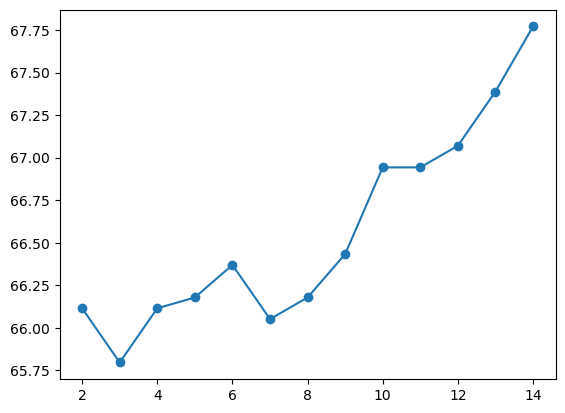

In [345]:
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

### Modification des categories en les dégroupants (plus facilement exploitables)

In [303]:
dataCat = data.loc[:, 'categories_tags'].str.split(',', expand = True)

In [304]:
dataCat.columns = ['categorie_level_' + str(x) for x in dataCat.columns]

In [305]:
dataCatFill = dataCat.ffill(axis=1)

In [306]:
dataCat.notna().sum()

categorie_level_0     12141
categorie_level_1     11399
categorie_level_2     10550
categorie_level_3      8767
categorie_level_4      6918
categorie_level_5      5258
categorie_level_6      4009
categorie_level_7      3047
categorie_level_8      2122
categorie_level_9      1285
categorie_level_10      854
categorie_level_11      522
categorie_level_12      325
categorie_level_13      147
categorie_level_14       80
categorie_level_15       29
categorie_level_16       13
categorie_level_17        5
categorie_level_18        3
categorie_level_19        2
categorie_level_20        1
categorie_level_21        1
dtype: int64

In [307]:
# data = data.drop(['quantity_unite_enc'], axis=1)

In [337]:
columnPredict = 'categorie_level_3'

listeTmp = data.copy()
listeTmp[columnPredict] = dataCatFill[columnPredict]

listeTmp = listeTmp.loc[~listeTmp[columnPredict].isna()]

# Liste des colonnes numériques avec plus de 40% de remplissage
listeColumns = listeColonesAlgo.copy()
listeColumns = list(listeTmp.dtypes.loc[lambda x : x != 'object'].index)
listeColumns = list(listeTmp[listeColumns].isna().mean().loc[lambda x : x < 0.6].index)

n = len(listeTmp)
listeTmp = listeTmp[listeColumns + [columnPredict]].dropna()
print(str( 100*(n - len(listeTmp))/n) + "% elements supprimés")

xtrain, xtest, ytrain, ytest = train_test_split(listeTmp[listeColumns], listeTmp[columnPredict] , train_size=0.8)

35.36776212832551% elements supprimés


In [338]:
# Encodage des categories
enc = LabelEncoder().fit(listeTmp[columnPredict])
ytrain = enc.transform(ytrain)
ytest = enc.transform(ytest)

In [339]:
knn = neighbors.KNeighborsClassifier(n_neighbors=8)
knn.fit(xtrain, ytrain)
error = 1 - knn.score(xtest, ytest)
print('Erreur: %f' % error)

Erreur: 0.742038


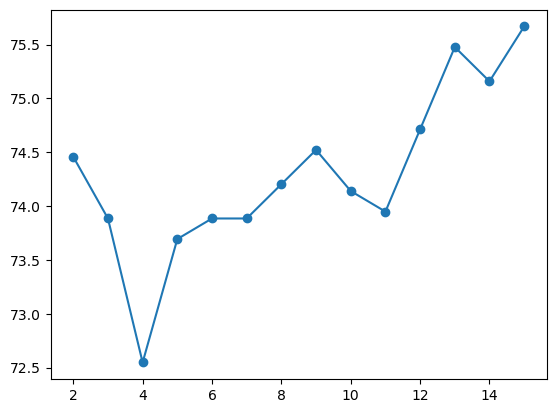

In [340]:
errors = []
for k in range(2,len(listeColumns)):
    knn = neighbors.KNeighborsClassifier(k)
    errors.append(100*(1 - knn.fit(xtrain, ytrain).score(xtest, ytest)))
plt.plot(range(2,len(listeColumns)), errors, 'o-')
plt.show()

# Test pour les 

In [353]:
level = 'categorie_level_4'
col = 'energy_100g'
colNew = col+'_mean'

In [354]:
dataGroup = data.copy()
dataGroup[level] = dataCatFill[level]

In [355]:
tmpGroup = dataGroup[[level, col]].groupby(by=level).agg(pd.Series.median)

In [356]:
mask = dataGroup[level].notna() & dataGroup[col].isna()
dataGroup.loc[mask,col] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])

In [357]:
mask = dataGroup[level].notna()

dataCompare = pd.DataFrame(columns=['data', 'methode'])

for methode, nom in [(pd.Series.median, 'median'), (pd.Series.mean, 'mean'), (pd.Series.min, 'min'), (pd.Series.max, 'max')]:
    tmpGroup = dataGroup[[level, col]].groupby(by=level).agg(methode)
    
    mask = dataGroup[level].notna()
    dataGroup.loc[mask,colNew] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])
    
    tmp =  pd.DataFrame(columns=['data', 'methode'])
    tmp['data'] = list((dataGroup[col] - dataGroup[colNew]).abs())
    tmp['methode'] = [nom]*len(dataGroup)
    dataCompare = pd.concat([dataCompare, tmp])
    
    print("Avec la méthode "+nom+" on obtient :")
    print(tmp['data'].describe())
    print('\n')

Avec la méthode median on obtient :
count    11373.000000
mean       133.756162
std        273.850034
min          0.000000
25%          0.000000
50%         37.000000
75%        129.000000
max       2701.500000
Name: data, dtype: float64


Avec la méthode mean on obtient :
count    11373.000000
mean       152.703939
std        243.476971
min          0.000000
25%         18.129032
50%         72.538462
75%        172.666667
max       2513.590909
Name: data, dtype: float64


Avec la méthode min on obtient :
count    11373.000000
mean       467.279106
std        590.393128
min          0.000000
25%         44.000000
50%        179.100000
75%        714.500000
max       3048.000000
Name: data, dtype: float64


Avec la méthode max on obtient :
count    11373.000000
mean       596.105090
std        685.642618
min          0.000000
25%         63.000000
50%        290.400000
75%       1003.000000
max       3048.000000
Name: data, dtype: float64




<AxesSubplot: xlabel='data', ylabel='methode'>

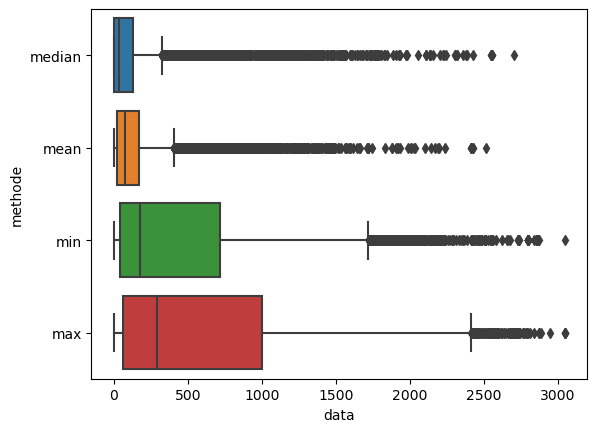

In [275]:
sns.boxplot(data=dataCompare, x='data', y='methode')

## Remplissage des données de miam

In [220]:
level = 'categorie_level_10'

dataGroup = data.copy()
dataGroup[level] = dataCatFill[level]

for col in ['energy_100g','fat_100g','saturated-fat_100g','omega-3-fat_100g','carbohydrates_100g','sugars_100g','fiber_100g',
'proteins_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g','nutrition-score-fr_100g']:
    colNew = col+'_mean'

    tmpGroup = dataGroup[[level, col]].groupby(by=level).median()

    mask = dataGroup[level].notna() & dataGroup[col].isna()
    data.loc[mask,col] = list(tmpGroup.loc[dataGroup.loc[mask,level], col])

## Remplissage des categories

## Verification de l'existence d'additifs

In [95]:
mauvais_additifs = set()
for i in data.index:
    val = data.loc[i, 'additives_tags']
    if val is np.NaN:
        continue
        
    listeA = data.loc[i, 'additives_tags'].split(',')
    for j in range(len(listeA)):
        a = listeA[i][3:]
        if a not in additifs:
            if a[3:-1] not in additifs and a[3:-2] not in additifs:
                pass
            mauvais_additifs.add(a[3:])
            
print(mauvais_additifs)

IndexError: list index out of range

In [ ]:
@interact
def show_articles_more_than(column=[c for c, d in zip(data.columns, data.dtypes) if d != 'object']):
    return data[column].plot.box()

In [ ]:
# Fonction pour détecter combien de colonnes contiennent une valeurs quand l'autre n'en a pas
def same_filling(data, c1, c2, affiche=True):
    mask  = data.loc[:, c1].isna()
    mask ^= data.loc[:, c2].isna()
    
    if not affiche:
        return mask
    
    nb = mask.sum()
    
    print("\nIl y a en tout", nb, "lignes différentes entre", c1, "et", c2, ".")
    if nb>0:
        dataSelect = data.loc[mask]
        print("Sur ces colonnes,", c1, "contient", dataSelect[c1].notna().sum(), "valeurs.")
        print("Et", c2, "contient", dataSelect[c2].notna().sum(), "valeurs.\n")
        print(dataSelect.loc[:, [c1, c2]].head(5))

In [ ]:
# Vérification des incohérences entre les colonnes avec et sans tag
for c in list(data.columns):
    if c.endswith('_tags') and c[:-5] in data.columns:
        same_filling(data, c, c[:-5])

In [ ]:
# Liste des colonnes avec tag
listeTags = pd.Series(data.columns).loc[data.columns.str.endswith('_tags')]

In [ ]:
# Suppression des lignes sans code (impossible à utiliser)
dataClean = data.loc[~dataClean['code'].isna()]
# Et vérification que les codes sont bien uniques (True  = oui)
len(dataClean.loc[dataClean['code'].duplicated()]) == 0

In [ ]:
# Reformate additives et remplis additives_tags
dataClean['additives_tags'] = dataClean['additives'].str.replace(r'\[[^\]>]*> ([a-z]{2}:[a-z0-9\-]+)[^\]]*\] *', r'\1,', regex=True)
dataClean['additives'] = dataClean['additives'].str.replace(r'\[ *([a-z0-9\-]+)[^\[]*', r'\1,', regex=True)

In [ ]:
# Met à NaN toutes les lignes dont tag est NaN (car c'est que la valeur nontag n'est pas valide)
for c1 in listeTags:
    c2 = c1[:-5]
    dataClean.loc[dataClean[c1].isna(), c2] = np.NaN
    if c2 in ['brands']: #Et pour brands on peut même faire l'inverse
        dataClean.loc[dataClean[c2].isna(), c1] = np.NaN

In [ ]:
# Normalise un texte pour en faire un tag
def to_tag(s):
    s = s.lower().strip()
    s = re.sub(r"( +|\')",'\-', s)
    s = re.sub(r'[^\w\s\-]','', s)
    s = unidecode(s)
    return s

In [ ]:
tagToText = {'huile-de-palme': 'Huile de palme'}

# Transforme un tag en texte
def to_text(s):
    oldS = s
    if s in tagToText:
        return tagToText[s]
    
    s = s.replace('-', ' ')
    s = s.capitalize()
    tagToText[oldS] = s
    return s

In [ ]:
# Ajout de la version humaine des tags
for c1 in ['ingredients_that_may_be_from_palm_oil_tags', 'ingredients_from_palm_oil_tags']:
    c2 = c1[:-5]
    mask = same_filling(dataClean, c1, c2, affiche=False)
    
    dataClean.loc[mask, c2] = dataClean.loc[mask, c1].str.split(',').apply(lambda t : ', '.join([to_text(x) for x in t]))

In [ ]:
dataClean.columns

In [ ]:
for c in dataClean.columns:
    if c.endswith('_100g'):
        dataClean[c]

In [ ]:
#dataClean['energy_100g'].plot(kind='box')

min_threshold,max_threshold = dataClean['energy_100g'].quantile([0.01,0.99])
print(min_threshold,max_threshold)

dataClean[(dataClean['energy_100g']<min_threshold)|(dataClean['energy_100g']>max_threshold)][['code', 'fat_100g','energy_100g']].sort_values(by='energy_100g')

In [ ]:
dataClean.loc[:, 'ingredients_from_palm_oil'].str.split(',', expand = True).stack().value_counts().plot(kind='barh', logx=True)

In [ ]:
dataClean['ingredients_that_may_be_from_palm_oil_tags'].str.split(',', expand = True).stack().value_counts().plot(kind='barh', logx=True)

In [ ]:
dataClean.loc[dataClean['brands_tags'].fillna('').str.contains(','), ['brands_tags', 'brands']]